In [65]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from xgboost import XGBClassifier

import fraud_detection as fd
from fraud_detection import data_loader, metrics

datapath = "./data/transformed_label_and_damage.parquet"

In [66]:
if os.getcwd().endswith("notebooks"):
    print("Changing current working directory to root of the project.")
    os.chdir("..")
else:
    print("Current working directory alread set to root of the project.")

Current working directory alread set to root of the project.


In [67]:
seed = 4
np.random.seed(seed)

In [68]:
X, targets = data_loader.load_data_np(datapath, drop_features=data_loader.useless_features)
#X = X.to_pandas()
#targets = targets.to_pandas()

X_train, X_test, y_train, y_test = train_test_split( X, targets, test_size=0.2, random_state=seed, stratify=targets[:, 0])

In [69]:
def create_model(calibration_method: str = "sigmoid", seed: int = 42):
    clf = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=seed,
        objective="binary:logistic",
    )

    if calibration_method not in [None, "sigmoid", "isotonic"]:
        raise ValueError("calibration_method must be either 'sigmoid' or 'isotonic' or None.")

    if not calibration_method:
        # If no calibration is needed, return the classifier directly
        return clf

    # Create stratified cross-validation splitter
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    model_with_calibration = CalibratedClassifierCV(
        estimator=clf, method=calibration_method, cv=cv
    )
    return model_with_calibration

In [77]:
def evaluate_calibration(model, X, y, calibration_method: str):
  # Calibration curve
  probs = model.predict_proba(X)[:, 1]
  prob_true, prob_pred = calibration_curve(y[:, 0], probs, n_bins=10)
  # Brier score
  print("Brier Score:", brier_score_loss(y[:, 0], probs))
  return prob_true, prob_pred

In [78]:
def experiment(X_train, y_train, X_test, y_test, calibration_method:str, seed=42):
    calibrated_model = create_model(calibration_method=calibration_method, seed=seed)
    calibrated_model.fit(X_train, y_train[:, 0])

    probs = calibrated_model.predict_proba(X_test)[:, 1]
    name = f"Calibrated XGBoost Classifier ({calibration_method})" if calibration_method else "XGBoost Classifier (no calibration)"
    metrics.propability_histogram(probs, y_test[:, 0], bins=25, name=name, save_to_file=False)
    return evaluate_calibration(calibrated_model, X_test, y_test, calibration_method=calibration_method)

Running experiment with calibration method: None


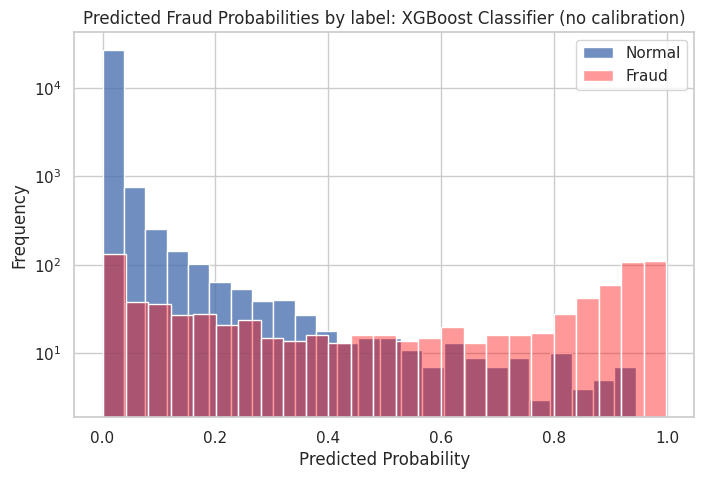

Brier Score: 0.013236068730356562
Running experiment with calibration method: sigmoid


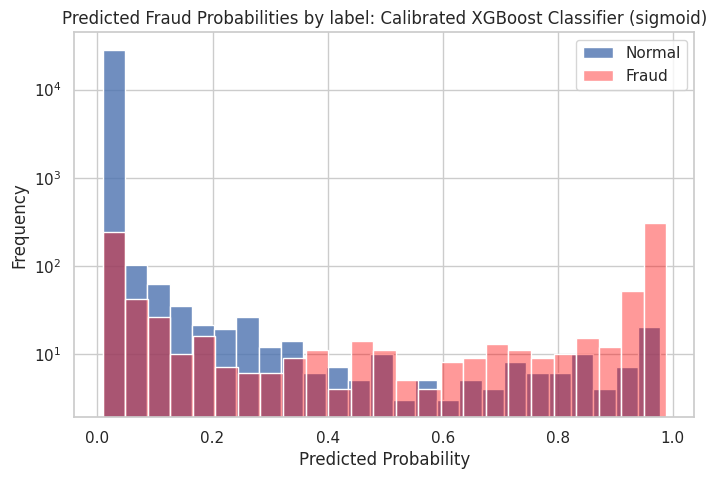

Brier Score: 0.014040975125068968
Running experiment with calibration method: isotonic


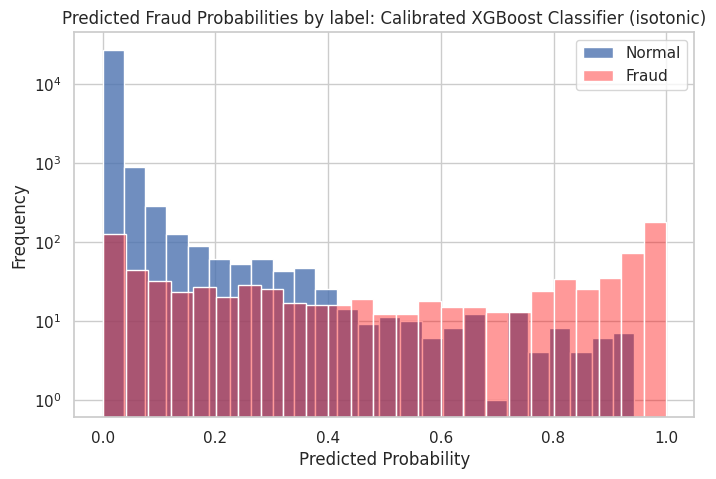

Brier Score: 0.013183712709149371


In [79]:
calibration_vals = dict()
for calibration_method in [None, "sigmoid", "isotonic"]:
    print(f"Running experiment with calibration method: {calibration_method}")
    prob_true, prob_pred = experiment(X_train, y_train, X_test, y_test, calibration_method=calibration_method, seed=seed)
    calibration_vals[calibration_method] = (prob_true, prob_pred)


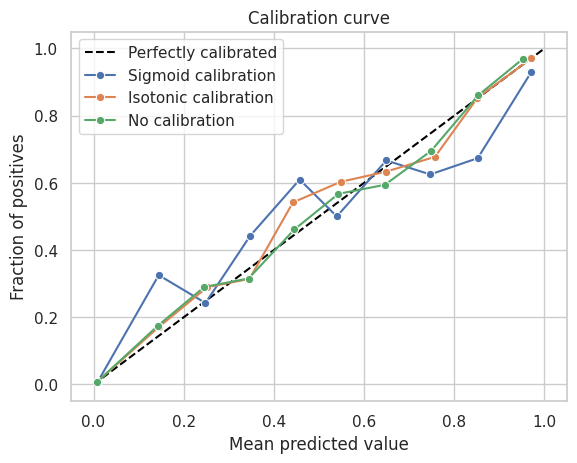

In [91]:
sns.set_theme(style="whitegrid")
sns.set_palette("deep")
sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Perfectly calibrated", color="black")
sns.lineplot(x=calibration_vals["sigmoid"][1], y=calibration_vals["sigmoid"][0], marker="o", label="Sigmoid calibration")
sns.lineplot(x=calibration_vals["isotonic"][1], y=calibration_vals["isotonic"][0], marker="o", label="Isotonic calibration")
sns.lineplot(x=calibration_vals[None][1], y=calibration_vals[None][0], marker="o", label="No calibration")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve")
plt.legend()
plt.show()

In [80]:
calibration_vals[None]

(array([0.00670974, 0.17391304, 0.29015544, 0.31531532, 0.46153846,
        0.56716418, 0.5942029 , 0.69491525, 0.86111111, 0.96958175]),
 array([0.00711296, 0.14188972, 0.24567411, 0.34371485, 0.44566419,
        0.5430649 , 0.64614795, 0.74844682, 0.85360461, 0.95270074]))